In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm

### Import

In [2]:
filename = './data/ML_IGE_ENTRANTS_MODELE2.csv'

In [3]:
df = pd.read_csv(filename,sep=';')

In [4]:
df.head()

,SITE,DATEDATA,SERVICE_ACTIVITE,TOTAL
0,MARSEILLE,2018-07-27,PRESTATION,1021
1,MARSEILLE,2018-12-31,PRESTATION,577
2,MARSEILLE,2019-07-17,CONTRAT - COTISATION,563
3,MARSEILLE,2019-03-14,RECLAMATION,40
4,MARSEILLE,2020-04-20,EXCLUDE,18


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8133 entries, 0 to 8132
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SITE              8133 non-null   object
 1   DATEDATA          8133 non-null   object
 2   SERVICE_ACTIVITE  8133 non-null   object
 3   TOTAL             8133 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 254.3+ KB


In [6]:
df['SITE']=df['SITE'].str.strip()
df['SITE']=df['SITE'].astype('category')
df['SERVICE_ACTIVITE']=df['SERVICE_ACTIVITE'].astype('category')
df['DATEDATA']=pd.to_datetime(df['DATEDATA'])

In [7]:
df.rename(columns={'SERVICE_ACTIVITE':'SERVICE','DATEDATA':'DATE'},inplace=True)

In [8]:
df.head()

,SITE,DATE,SERVICE,TOTAL
0,MARSEILLE,2018-07-27,PRESTATION,1021
1,MARSEILLE,2018-12-31,PRESTATION,577
2,MARSEILLE,2019-07-17,CONTRAT - COTISATION,563
3,MARSEILLE,2019-03-14,RECLAMATION,40
4,MARSEILLE,2020-04-20,EXCLUDE,18


### Filter

In [9]:
df['SITE'].unique()

[MARSEILLE, COURBEVOIE, VELIZY, LYONGDL]
Categories (4, object): [MARSEILLE, COURBEVOIE, VELIZY, LYONGDL]

In [10]:
df['SERVICE'].unique()

[PRESTATION, CONTRAT - COTISATION, RECLAMATION, EXCLUDE, TRANSVERSE, PREVOYANCE, SRC]
Categories (7, object): [PRESTATION, CONTRAT - COTISATION, RECLAMATION, EXCLUDE, TRANSVERSE, PREVOYANCE, SRC]

In [12]:
df_filter = df[(df['SITE']=='VELIZY') & (df['SERVICE']=='PRESTATION') & (df['DATE']<'2020-01-01') ]

In [13]:
df_filter

,SITE,DATE,SERVICE,TOTAL
30,VELIZY,2018-03-16,PRESTATION,986
31,VELIZY,2018-08-20,PRESTATION,819
65,VELIZY,2019-10-09,PRESTATION,1265
82,VELIZY,2018-10-11,PRESTATION,1436
103,VELIZY,2019-09-13,PRESTATION,907
...,...,...,...,...
8054,VELIZY,2018-10-09,PRESTATION,1373
8071,VELIZY,2018-05-08,PRESTATION,121
8075,VELIZY,2019-11-05,PRESTATION,1301
8107,VELIZY,2019-05-06,PRESTATION,1484


### Create Aggregated Df with DatTime Index

In [14]:
df2 = df_filter.groupby('DATE').sum()

In [15]:
df2 = df2.asfreq(freq='B')

In [16]:
df2.index

DatetimeIndex(['2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='DATE', length=512, freq='B')

### Split in train test to compare with predictions

In [17]:
from pmdarima.model_selection import train_test_split
train,test = train_test_split(df2, test_size=30)

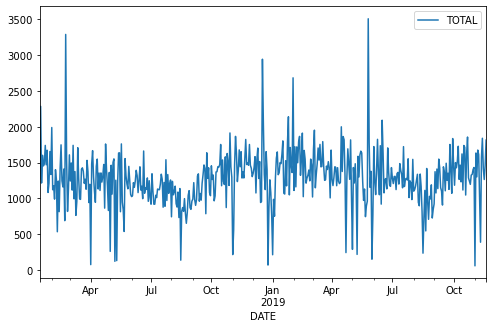

In [18]:
plt.rcParams['figure.figsize'] = [8, 5]
train.plot();

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 482 entries, 2018-01-15 to 2019-11-19
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TOTAL   482 non-null    int64
dtypes: int64(1)
memory usage: 7.5 KB


### Decompose

In [ ]:
# DECOMPOSE NOT WORKING !!!

# TO CHECK

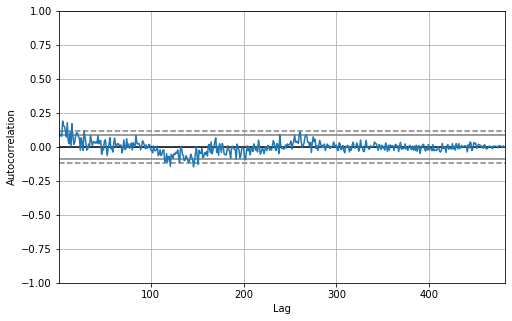

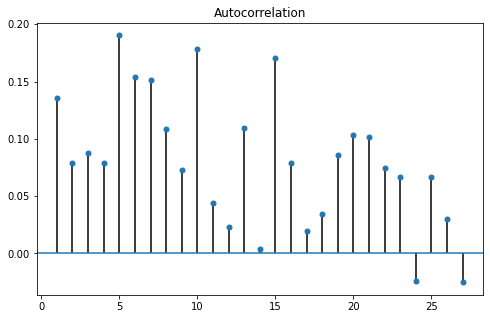

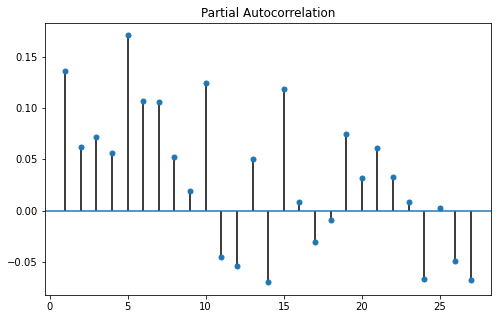

In [20]:
from pmdarima import utils

utils.autocorr_plot(train)
utils.plot_acf(train,zero=False)
utils.plot_pacf(train,zero=False)

NameError: name 'ausbeer' is not defined

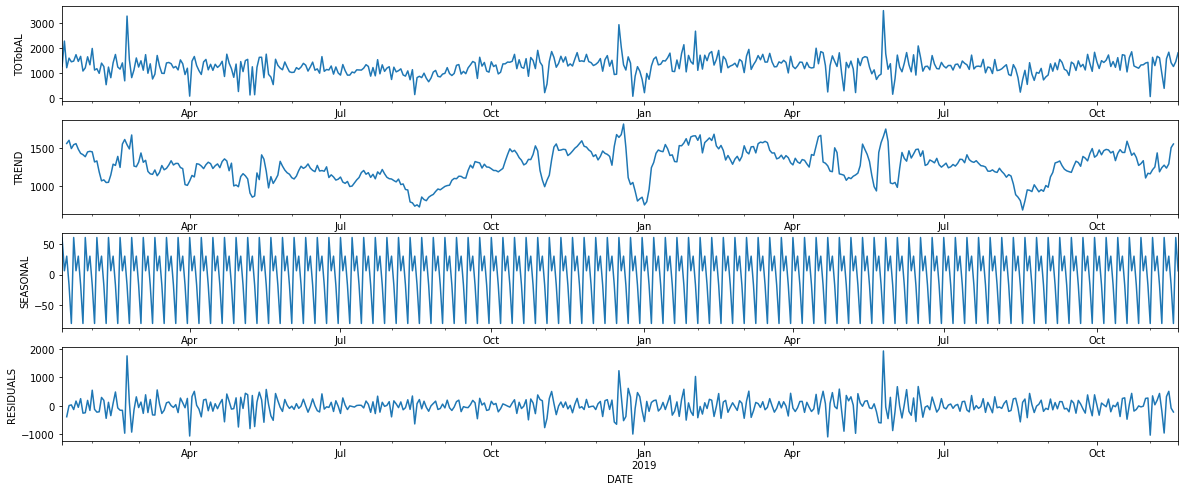

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train.TOTAL.interpolate(),period=5, model='additive')

# resplot = res.plot()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(20,8))
ax0.set_ylabel('TOTobAL')
ax1.set_ylabel('TREND')
ax2.set_ylabel('SEASONAL')
ax3.set_ylabel('RESIDUALS')


res.observed.plot(ax=ax0);
res.trend.plot(ax=ax1);
res.seasonal.plot(ax=ax2);
res.resid.plot(ax=ax3);

In [23]:
res.observed[:10]

DATE
2018-01-15    1272.0
2018-01-16    2286.0
2018-01-17    1215.0
2018-01-18    1602.0
2018-01-19    1454.0
2018-01-22    1482.0
2018-01-23    1740.0
2018-01-24    1470.0
2018-01-25    1673.0
2018-01-26    1083.0
Freq: B, Name: TOTAL, dtype: float64

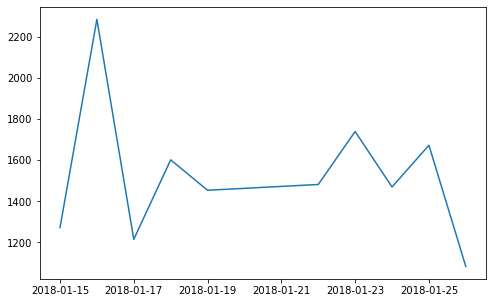

In [24]:
plt.plot(res.observed[:10])

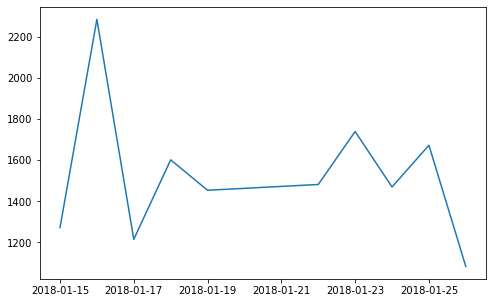

In [25]:
plt.plot(train.TOTAL[:10])

### ACF / PACF

In [38]:
# Fit a simple auto_arima model
modl = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=True, m=5)



Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,5) [intercept=True]; AIC=7073.594, BIC=7107.001, Time=0.675 seconds
Fit ARIMA(0,1,0)x(0,0,0,5) [intercept=True]; AIC=7358.964, BIC=7367.315, Time=0.029 seconds
Fit ARIMA(1,1,0)x(1,0,0,5) [intercept=True]; AIC=7241.597, BIC=7258.301, Time=0.154 seconds
Fit ARIMA(0,1,1)x(0,0,1,5) [intercept=True]; AIC=7078.836, BIC=7095.539, Time=0.367 seconds
Fit ARIMA(0,1,0)x(0,0,0,5) [intercept=False]; AIC=7356.967, BIC=7361.143, Time=0.019 seconds
Fit ARIMA(2,1,2)x(0,0,1,5) [intercept=True]; AIC=7076.724, BIC=7105.955, Time=0.654 seconds
Fit ARIMA(2,1,2)x(1,0,0,5) [intercept=True]; AIC=7076.089, BIC=7105.320, Time=0.546 seconds
Fit ARIMA(2,1,2)x(2,0,1,5) [intercept=True]; AIC=7072.767, BIC=7110.349, Time=0.977 seconds
Fit ARIMA(2,1,2)x(2,0,0,5) [intercept=True]; AIC=7073.490, BIC=7106.897, Time=0.838 seconds
Fit ARIMA(2,1,2)x(2,0,2,5) [intercept=True]; AIC=7075.287, BIC=7117.045, Time=1.190 seconds
Fit ARIMA(2,1,2)x(1,0,2,5) [intercep

In [40]:
from sklearn.metrics import mean_squared_error
# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 364.979


In [35]:
arima.seasonal_order

(1, 0, 1, 5)

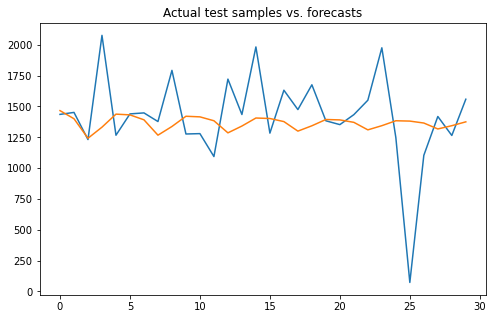

In [37]:
import numpy as np
# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test)
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

AttributeError: 'function' object has no attribute 'shape'

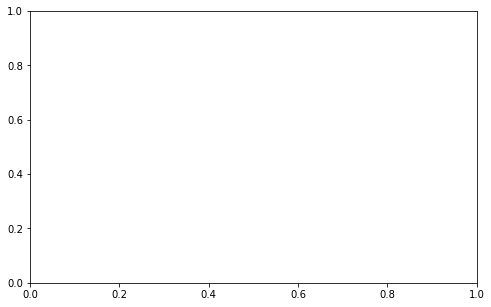

In [45]:
utils.plot_acf(modl.resid)